# Generating fake data for neo4j analysis 

## Tasks 

* Define relevant node types
    - tilt 
        - meta  
        - dataDisclosed
            - Recipient
            - purposes
* Generate nodes 
    * Get list of company names
    * Define likelihood of same connections (sample size / no. of companies)
* Construct mutation (possibly combine with previous step)
* Figure out how to upload to neo4j as separate graph
* Do analysis

In [37]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import time
import random as rd
from scipy.stats import poisson
import neo4j
import matplotlib.pyplot as plt



def get_table(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')
    
    elems = []
    for child in soup.find_all('table')[0].children:

        for some in child:
            row = []
            for i,td in enumerate(some):
                try:
                    row.append(td.text.replace('\n',""))
                except:
                    continue
                if len(row) > 0:
                    elems.append(row)

    return elems
    

table = get_table("https://www.zyxware.com/articles/4344/list-of-fortune-500-companies-and-their-websites")
subset = [[table[i][1],table[i][3], table[i][5]]   for i in range(0,len(table), 7)]
fortune_500 = pd.DataFrame(subset[1:], columns=subset[0])


In [3]:
import pickle

In [4]:
#fortune_500.to_csv("fortune_500")

fortune_500 = pd.read_csv('fortune_500')

with open ('categories_tilt', 'rb') as fp:
    categories = pickle.load(fp)

with open ('purpose_tilt', 'rb') as fp:
    purpose = pickle.load(fp)

In [45]:
[i for i in range(5)]

[0, 1, 2, 3, 4]

## Using the Python Driver

In [129]:
from neo4j import GraphDatabase

class exampleTilt:

    """
    class:  exampleTilt
    input:  - uri: bolt uri from neo4j
            - auth: credentials for neo4j
            - no_nodes: number of nodes to create 
            - comp_df:  dataframe with company names and websites
            - mu_poisson_*: average no. of samples for poisson distribution
            - reset: whether to delete all nodes in database (default False, meant for experimentation)

    """

    def __init__(self, uri, auth, no_nodes, comp_df, category_list, purpose_list, mu_poisson_dataDisclosed =2,  mu_poisson_recipients = 2, reset = False, no_clusters = 5):
        self.driver = GraphDatabase.driver(uri, auth=auth)
        self.categories = category_list
        self.purposes = purpose_list
        self.reset = reset

        #number of nodes to push
        self.no_nodes = no_nodes
        
        #company names
        self.company_df = comp_df

        #hyperparameters
        self.mu_poisson_dataDisclosed = mu_poisson_dataDisclosed
        self.mu_poisson_recipients = mu_poisson_recipients
        self.no_clusters = no_clusters
        
        #sort into fake clusters 
        self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(comp_df))]

        print(self.company_df.head())


    def close(self):
        self.driver.close()

    # Create a person node.
    @classmethod
    def createTilt(cls, tx, id, comp_name, url, cluster):
        tx.run("MERGE (t:tilt {id: 0})-[:has_meta]->(m:meta {_id: $id, name: $company_name, created: $created, modified: $placeholder, version: $placeholder, language: $placeholder,  status: $placeholder, url: $url, cluster: $cluster, _hash: $placeholder}) ",
            id=id, 
            cluster = cluster,
            company_name = comp_name, 
            created = 3, #time.strftime("%Y:%m:%d, %H:%M:%S"),  we cannot use it with the merge statements because it makes the meta node unique. might have to come up with something here. placeholder it for now.
            url = url, 
            placeholder = 'None')
            
    def createDataDisclosed(self, tx,comp_name, _id, cluster):
        tx.run("MATCH (t:tilt)-[:has_meta]->(m:meta {name: $company_name}) "
               "MERGE (t)-[:has_dataDisclosed]->(d:dataDisclosed {_id: $_id, category: $placeholder, legalBases: $placeholder, legitimateInterests: $placeholder, nonDisclosure: $placeholder, storage: $placeholder}) "
               "MERGE (d)-[:has_purpose]->(p:purpose {purpose: $purpose, description: $placeholder}) ",
                company_name = comp_name, 
                purpose = rd.choice(self.purposes),
                _id=_id, 
                placeholder = 'Lorem Ipsum'      
        )

        # define weights dict
        weights = {}

        # fill with no of clusters 
        for n in range(self.no_clusters):
            weights[f'{n}'] = 1/self.no_clusters

        # increase weight for cluster of company
        weights[cluster] = weights[cluster]*3  # another hyperparameter can be how much the weight is scaled

        # scale the weights
        scaled_weights = (pd.Series(weights) / self.company_df.cluster.value_counts(normalize=True))

        # add recipients (as many as drawn from poisson)
        for _ in range(poisson.rvs(self.mu_poisson_recipients, size=1)[0]):
            
            # select company to share info with df.loc[df['column_name'] == some_value]
            shared_with_comp = self.company_df.loc[self.company_df['Company'] != comp_name].sample(n=1, weights=self.company_df.cluster.map(scaled_weights))

            # create recipient
            tx.run("MATCH (d:dataDisclosed {_id: $_id}) " 
                    "MERGE (d)-[:has_recipient]->(r:recipient {name: $name, division: $placeholder, address: $placeholder, country: $placeholder, representative: $placeholder, email: $placeholder, phone: $placeholder, category: $placeholder}) ",
                    name = shared_with_comp['Company'].values[0],
                    placeholder = "Lorem Ipsum",
                    _id = _id
                    )

    # Match and display all friendships.
    @classmethod
    def print_friendships(cls, tx):
        result = tx.run("MATCH (a)-[:KNOWS]->(b) RETURN a.name, b.name")
        for record in result:
            print("{} knows {}".format(record["a.name"], record["b.name"]))

    @classmethod
    def delete_nodes(cls, tx):
        tx.run("MATCH (n) detach delete n")

    
    def get_sorensen(self, tx, threshold = .9):
        tx.run("MATCH (m:meta), (r:recipient) "
                f"WHERE apoc.text.sorensenDiceSimilarity(apoc.text.clean(m.name), apoc.text.clean(r.name), 'en') > {threshold} "
                "MERGE (m)-[c:has_sorensen]->(r)")


    def main(self):
        saved_bookmarks = []  # To collect the session bookmarks

        if self.reset:
            with self.driver.session() as session_del:
                session_del.write_transaction(self.delete_nodes)
                saved_bookmarks.append(session_del.last_bookmark())


        for i in range(self.no_nodes):
            
            with self.driver.session() as session_a: 
                session_a.write_transaction(self.createTilt, 
                                            str(self.company_df['Rank'][i]), 
                                            self.company_df['Company'][i], 
                                            self.company_df['Website'][i], 
                                            str(self.company_df['cluster'][i]))

                for d in range(poisson.rvs(self.mu_poisson_dataDisclosed, size=1)[0]):
                    session_a.write_transaction(self.createDataDisclosed, 
                                                self.company_df['Company'][i], 
                                                d, str(self.company_df['cluster'][i]))
                saved_bookmarks.append(session_a.last_bookmark())

        with self.driver.session() as session_sorensen: 
            session_sorensen.write_transaction(self.get_sorensen)


fakeTilt = exampleTilt(uri = 'bolt://localhost:11003', 
                    auth = ('neo4j', 'letmein'), 
                    no_nodes= 50,
                    comp_df= fortune_500,
                    category_list = categories, 
                    purpose_list = purpose,
                    mu_poisson_dataDisclosed = 1,
                    mu_poisson_recipients= 1,
                    reset=True)

  Rank             Company                             Website cluster
0    1             Walmart            https://www.walmart.com/       4
1    2              Amazon             https://www.amazon.com/       4
2    3               Apple              https://www.apple.com/       3
3    4          CVS Health          https://www.cvshealth.com/       4
4    5  UnitedHealth Group  https://www.unitedhealthgroup.com/       0


In [130]:
fakeTilt.main()

## Using the GDS library for python

documentation https://neo4j.com/docs/graph-data-science-client/current/getting-started/


In [7]:
from graphdatascience import GraphDataScience

In [32]:
gds.graph.exists('neo_meta_sorensen')

graphName    neo_meta_sorensen
exists                    True
Name: 0, dtype: object

In [35]:
gds = GraphDataScience('bolt://localhost:11003', 
                    auth = ('neo4j', 'letmein'))

gds.graph.list()
g_meta = gds.graph.get("neo_meta_sorensen")
#g_meta, _ = gds.graph.project("neo_meta_sorensen", ["meta", "dataDisclosed", "recipient"], "has_sorensen")

(array([2.209e+03, 4.300e+01, 5.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([0.15   , 0.16275, 0.1755 , 0.18825, 0.201  , 0.21375, 0.2265 ,
        0.23925, 0.252  , 0.26475, 0.2775 ]),
 <BarContainer object of 10 artists>)

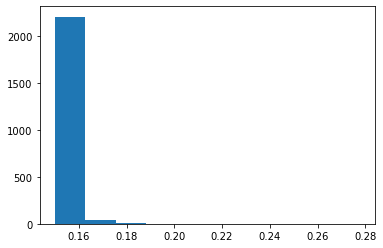

In [38]:
res = gds.pageRank.stream(g_meta)

plt.hist((res.sort_values(by=['score'], ascending=False))['score'])

## Visuals

#### Doku
- https://hub.graphistry.com/docs/ui/index/
- https://github.com/graphistry/pygraphistry/blob/master/demos/demos_databases_apis/neo4j/official/graphistry_bolt_tutorial_public.ipynb
- https://hub.graphistry.com/

In [10]:
#!pip install --user graphistry

import graphistry

In [13]:
NEO4J = {
        'uri':'bolt://localhost:11003', 
        'auth' : ('neo4j', 'letmein')
}

graphistry.register(api=3, username='j_halkenhaeusser', password='longlivetransparency22', protocol='https', server='hub.graphistry.com')
graphistry.register(bolt=NEO4J)


In [131]:
g = graphistry.cypher("""
      MATCH (t:tilt)-[c_m:has_meta]-(m:meta)-[c_d:has_dataDisclosed]-(d:dataDisclosed)-[c_r:has_]-(r:recipient)-[]-(m:meta) RETURN t, m, d, r
  """)

g.plot()

/Users/johannes/.local/lib/python3.9/site-packages/graphistry/util.py:242: RuntimeWarning: Query returned no edges; may have surprising visual results or need to add missing columns for encodings
  warnings.warn(RuntimeWarning(msg))
/Users/johannes/.local/lib/python3.9/site-packages/graphistry/util.py:242: RuntimeWarning: Query returned no nodes
  warnings.warn(RuntimeWarning(msg))
/Users/johannes/.local/lib/python3.9/site-packages/graphistry/util.py:242: RuntimeWarning: Graph has no edges, may have rendering issues
  warnings.warn(RuntimeWarning(msg))


## Generate Nodes (function) (bulky graphql queries)

In [219]:
def build_mutations(node_count, company_names, mu_poisson):

    """
    func:   build_mutations
            Generates a mutation string to pass to graphQL API that generates a node
    """

    #define categories of data usage
    categories = ["Personalised Ads", "Social Media", "Cookies", "purpose 1", "purpose 2", "purpose 3", "purpose 4", "purpose 5"]

    #empty list with mutations
    mutations = []

    #make node_count mutations
    for i in range(node_count):
        # initialize
        output_string = 'mutation { createtilts( input: [ { '
        
        # add tilt and meta data
        output_string += f'_id:{{create:[{{oid: "{rd.randrange(1000)}"}}]}}meta:{{create:[{{_id: "{i}", name: "{company_names["Company"][i]}", created: "{time.strftime("%Y:%m:%d, %H:%M:%S")}", modified: "None", version: "1", language: "en", status: "active", url: "{company_names["Website"][i]}", _hash:"some hash" }}]}}' 
        
        output_string += 'dataDisclosed:{create:['
        for d in range(poisson.rvs(mu_poisson, size=1)[0]):
        # add dataDisclosed 
            output_string += f'{{_id: "{i}_{d}", category: "{rd.choice(categories)}", purposes:{{create:[{{}}]}}legalBases:{{create:[{{}}]}}legitimateInterests:{{create:[{{reasoning: "Lorem Ipsum", exists: "True"}}]}}recipients:{{create:[{{name: "{company_names["Company"][rd.randrange(500)]}", country: "None", division: "None", address: "None", representative:{{create:[{{name: "None", email: "None", phone: "None"}}]}}category: "None"}}]}}storage:{{create:[{{}}]}}nonDisclosure:{{create:[{{consequences: "Lorem Ipsum", legalRequirement: "False", contractualRegulation: "True", obligationToProvide: "False"}}]}}}}'

        # complete string
        output_string += ']} }] ) {tilts {meta { name } } } }'

        mutations.append(output_string)

    return mutations

In [220]:
#hyperparameters

#number of nodes
no_nodes_hyp = 30

#average number of recipients in data disclosed (drawn from poisson)
mu_poisson_hyp = 2


build_mutations(1, fortune_500, mu_poisson= mu_poisson_hyp)

['mutation { createtilts( input: [ { _id:{create:[{oid: "220"}]}meta:{create:[{_id: "0", name: "Walmart", created: "2022:08:23, 09:44:39", modified: "None", version: "1", language: "en", status: "active", url: "https://www.walmart.com/", _hash:"some hash" }]}dataDisclosed:{create:[{_id: "0_0", category: "Social Media", purposes:{create:[{}]}legalBases:{create:[{}]}legitimateInterests:{create:[{reasoning: "Lorem Ipsum", exists: "True"}]}recipients:{create:[{name: "DXC Technology", country: "None", division: "None", address: "None", representative:{create:[{name: "None", email: "None", phone: "None"}]}category: "None"}]}storage:{create:[{}]}nonDisclosure:{create:[{consequences: "Lorem Ipsum", legalRequirement: "False", contractualRegulation: "True", obligationToProvide: "False"}]}}{_id: "0_1", category: "Social Media", purposes:{create:[{}]}legalBases:{create:[{}]}legitimateInterests:{create:[{reasoning: "Lorem Ipsum", exists: "True"}]}recipients:{create:[{name: "Cincinnati Financial", c

In [306]:
fortune_500

,Unnamed: 0,Rank,Company,Website
0,0,1,Walmart,https://www.walmart.com/
1,1,2,Amazon,https://www.amazon.com/
2,2,3,Apple,https://www.apple.com/
3,3,4,CVS Health,https://www.cvshealth.com/
4,4,5,UnitedHealth Group,https://www.unitedhealthgroup.com/
...,...,...,...,...
495,495,496,Hasbro,https://shop.hasbro.com/
496,496,497,Roper Technologies,https://www.ropertech.com/
497,497,498,ARKO,https://www.arkocorp.com/
498,498,499,Frontier Communications,https://frontier.com/


### Upload to NEO4J

In [207]:
from tqdm import tqdm
import re
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport

# console = Console()

sample_transport=RequestsHTTPTransport(
    url='http://localhost:4001/graphql',
    use_json=True,
    headers={
        "Content-type": "application/json",
    },
    verify=False
)

client = Client(
    #execute_timeout=20,
    transport=sample_transport,
    fetch_schema_from_transport=True,
)


successes = 0
for i, query_string in enumerate(tqdm(build_mutations(50, fortune_500))):
    #print("Query String: ", query_string)
    try:
        query = gql(query_string)
        #client.execute(query)
        successes += 1
    except Exception as syn:
        print(syn)
        print("Error With Tilt No.", i)

print("Successfully Uploaded:", 100*(successes/(i+1)), "per. of tilts")

100%|██████████| 50/50 [00:00<00:00, 272.04it/s]

Successfully Uploaded: 100.0 per. of tilts
